# Import libraries

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting toolkit
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys

2025-08-20 06:44:21.649722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 06:44:21.663031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 06:44:21.799695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 06:44:21.888150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755665061.962439    3403 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755665061.98

In [2]:
from scripts.parse_vars import parse_variables

In [3]:
path_vars = f"../../geno_simulation.txt"
R_directory = f"../../rstudio_geno_simulation"
R_file = f"create_geno.R"

variables = parse_variables(path_vars)
if 'G' not in globals():
    G = int(variables['G'])
if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])
if 'F' not in globals():
    F = float(variables['F'])

# Load variables

In [4]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete_inbred.pkl"))

In [5]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
pheno = pd.read_pickle(f"{path_pheno}/env_pheno.pkl")
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")

In [6]:
pheno

x   y  01_pheno_linear  02_pheno_sine_x  03_pheno_sine_y  \
0      1   1             -1.0         0.856410     6.210526e-01   
1      1   1             -1.0         0.856410     6.210526e-01   
2      1   1             -1.0         0.856410     6.210526e-01   
3      1   1             -1.0         0.856410     6.210526e-01   
4      1   1             -1.0         0.856410     6.210526e-01   
...   ..  ..              ...              ...              ...   
1995  10  10              1.0         0.025641    -1.110223e-16   
1996  10  10              1.0         0.025641    -1.110223e-16   
1997  10  10              1.0         0.025641    -1.110223e-16   
1998  10  10              1.0         0.025641    -1.110223e-16   
1999  10  10              1.0         0.025641    -1.110223e-16   

      04_pheno_sine_x_y  05_pheno_discrete  
0              0.740260                  0  
1              0.740260                  0  
2              0.740260                  0  
3              0.740260                  0  
4              0.740260                  0  
...                 ...                ...  
1995           0.012987                  0  
1996           0.012987                  0  
1997           0.012987                  0  
1998           0.012987                  0  
1999           0.012987                  0  

[2000 rows x 7 columns]

In [7]:
pheno_list = list(pheno[[col for col in pheno.columns if col not in ['x', 'y']]].columns)

In [8]:
pheno_list

['01_pheno_linear',
 '02_pheno_sine_x',
 '03_pheno_sine_y',
 '04_pheno_sine_x_y',
 '05_pheno_discrete']

In [21]:
nr_pcs = 5

In [22]:
geno_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl")
min_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/minor_{nr_pcs}_PCs.pkl")
het_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/het_{nr_pcs}_PCs.pkl")
maj_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/major_{nr_pcs}_PCs.pkl")


In [23]:
geno_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/geno_reconstruct_{nr_pcs}_PCs.pkl")
min_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/minor_reconstruct_{nr_pcs}_PCs.pkl")
het_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/het_reconstruct_{nr_pcs}_PCs.pkl")
maj_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/major_reconstruct_{nr_pcs}_PCs.pkl")

In [24]:
error = 1-(min_reconstruct+ het_reconstruct+ maj_reconstruct)

In [25]:
row_means = (geno_reconstruct - ((maj_reconstruct - min_reconstruct) + error)).mean(axis=0)
#row_means = (geno_reconstruct - (((1-min_reconstruct-het_reconstruct) - min_reconstruct))).mean(axis=0)



In [26]:
row_means

C_1_MAF_0.500        -9.407010e-08
C_2_MAF_0.500        -5.887821e-09
C_3_MAF_0.500        -1.440886e-07
C_4_MAF_0.500        -2.380926e-07
C_5_MAF_0.500        -1.379624e-07
                          ...     
VR_39996_MAF_0.041   -5.600750e-07
VR_39997_MAF_0.040   -4.900694e-07
VR_39998_MAF_0.040   -5.312264e-07
VR_39999_MAF_0.039   -4.555583e-07
VR_40000_MAF_0.038   -6.136894e-07
Length: 40000, dtype: float32

# PCA

In [27]:
geno_pcs

PC1        PC2        PC3       PC4        PC5
0     25.884207  88.060868 -58.395915 -4.514123  34.805124
1     25.917719  88.946659 -58.643488 -4.229052  35.180885
2     26.246525  88.713698 -58.344755 -4.897007  34.377725
3     26.865916  89.432531 -58.205205 -5.007013  33.396345
4     26.793539  88.125058 -58.008437 -4.050834  34.769877
...         ...        ...        ...       ...        ...
1995 -24.513327 -80.637052 -65.647345  1.676225  34.663614
1996 -24.658386 -81.050649 -67.432683  1.110680  34.273886
1997 -24.523911 -80.174247 -66.193889  1.222380  33.879151
1998 -25.374098 -80.651572 -66.482199  0.366960  34.142188
1999 -25.226845 -80.864091 -66.285598  1.114887  33.429045

[2000 rows x 5 columns]

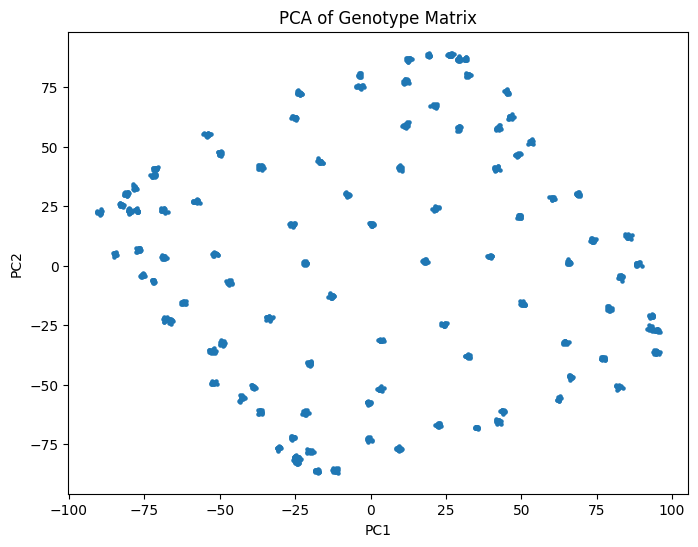

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(geno_pcs['PC1'], geno_pcs['PC2'], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix")
plt.show()


# Gwas

In [29]:
env_factor = "04_pheno_sine_x_y"

In [30]:
from statsmodels.api import OLS, add_constant
import numpy as np
import pandas as pd

# Extract phenotype
y = pheno[env_factor].values

# Initialize results list
results = []

# Loop through SNPs
for snp in geno.columns:
    x = geno[snp].values
    # Combine SNP with PCs
    X = pd.concat([pd.Series(x, name='SNP'), geno_pcs], axis=1)
    X = add_constant(X)  # Add intercept
    model = OLS(y, X).fit()
    pval = model.pvalues['SNP']  # p-value for SNP term
    logp = -np.log10(pval)
    results.append((snp, logp))

# Create and sort results DataFrame
gwas_results = pd.DataFrame(results, columns=['SNP', '-log10(p)'])
gwas_results = gwas_results.sort_values('-log10(p)', ascending=False).reset_index(drop=True)

# Display
gwas_results


SNP  -log10(p)
0      R_21939_MAF_0.104  79.908511
1      R_15307_MAF_0.170  79.576276
2      R_21872_MAF_0.105  76.798173
3      R_21605_MAF_0.107  75.247126
4      R_15290_MAF_0.170  71.906135
...                  ...        ...
39995  R_27531_MAF_0.074   0.000247
39996   C_8469_MAF_0.286   0.000214
39997  R_32363_MAF_0.061   0.000206
39998  R_35616_MAF_0.055   0.000046
39999  R_17198_MAF_0.148   0.000044

[40000 rows x 2 columns]

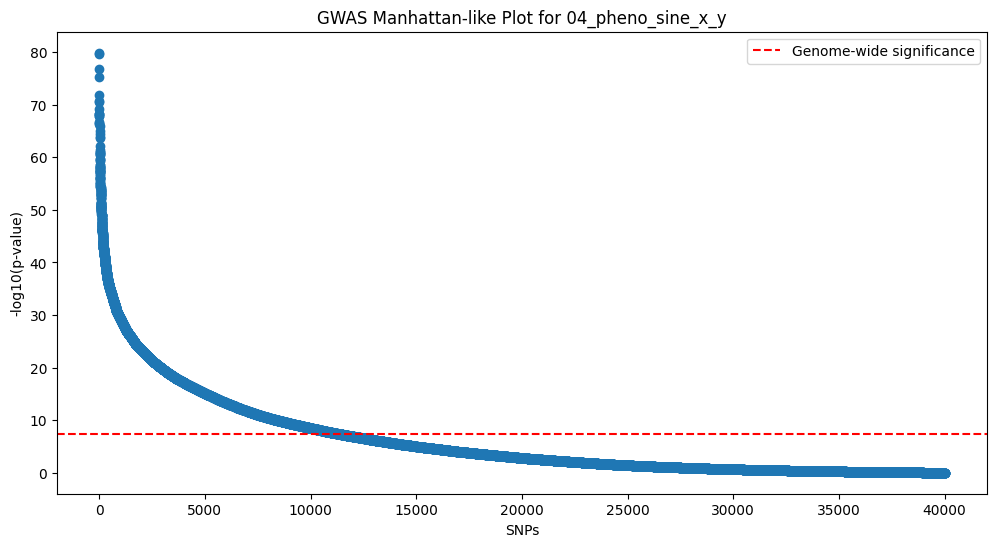

In [31]:


plt.figure(figsize=(12, 6))
plt.plot(gwas_results['-log10(p)'].values, marker='o', linestyle='none')
plt.axhline(-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide significance')
plt.xlabel('SNPs')
plt.ylabel('-log10(p-value)')
plt.title(f'GWAS Manhattan-like Plot for {env_factor}')
plt.legend()
plt.show()

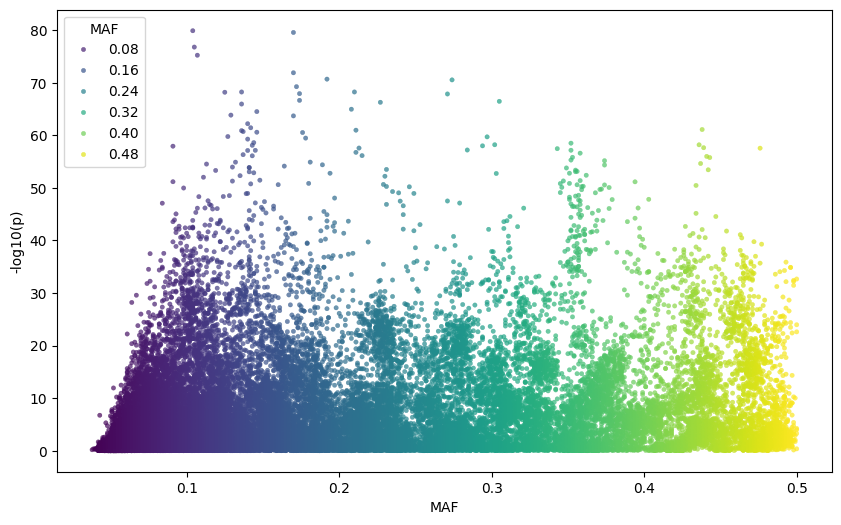

In [32]:


# Extract MAF from SNP names
gwas_results['MAF'] = gwas_results['SNP'].str.extract(r'MAF_([\d.]+)').astype(float)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="MAF",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)


In [33]:
gwas_results['maf_deviation'] = gwas_results['SNP'].map(row_means)
gwas_results['maf_deviation_abs'] = gwas_results['maf_deviation'].abs()

In [34]:
gwas_results

SNP  -log10(p)    MAF  maf_deviation  maf_deviation_abs
0      R_21939_MAF_0.104  79.908511  0.104  -3.269613e-07       3.269613e-07
1      R_15307_MAF_0.170  79.576276  0.170  -2.865344e-07       2.865344e-07
2      R_21872_MAF_0.105  76.798173  0.105  -3.196299e-07       3.196299e-07
3      R_21605_MAF_0.107  75.247126  0.107  -3.618449e-07       3.618449e-07
4      R_15290_MAF_0.170  71.906135  0.170  -2.529621e-07       2.529621e-07
...                  ...        ...    ...            ...                ...
39995  R_27531_MAF_0.074   0.000247  0.074  -4.098862e-07       4.098862e-07
39996   C_8469_MAF_0.286   0.000214  0.286  -9.208173e-08       9.208173e-08
39997  R_32363_MAF_0.061   0.000206  0.061  -4.088283e-07       4.088283e-07
39998  R_35616_MAF_0.055   0.000046  0.055  -4.404485e-07       4.404485e-07
39999  R_17198_MAF_0.148   0.000044  0.148  -1.918972e-07       1.918972e-07

[40000 rows x 5 columns]

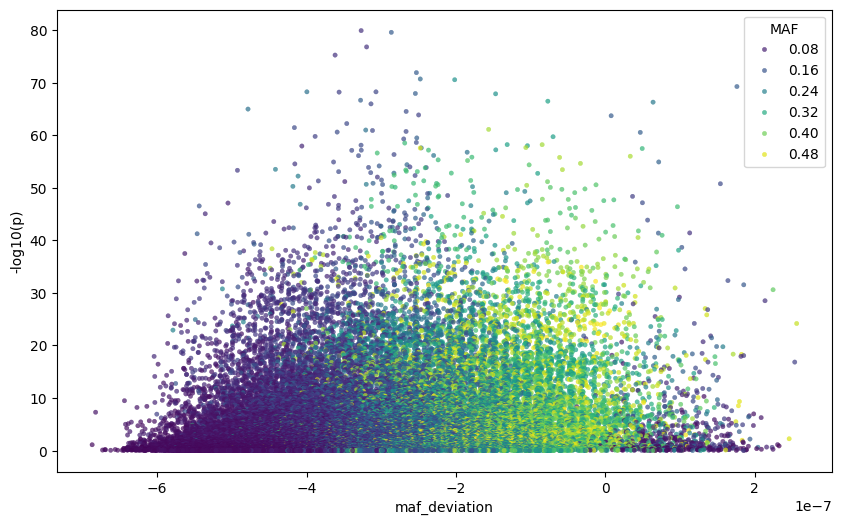

In [35]:

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="maf_deviation",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)

# Lets iterate through the PCs 

In [36]:
nrs_pcs = list(set([int(f.split("_")[1]) for f in os.listdir(f"simulation_data//G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs")]))

In [42]:
done_pheno_list = [f.split(".pkl")[0] for f in os.listdir(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons") if f.endswith(".pkl")]

In [44]:
pheno_list_to_do = [p for p in pheno_list if p not in done_pheno_list]

In [46]:
"""
os.makedirs(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons", exist_ok=True)

EPS = np.finfo(float).tiny  # smallest positive float

for env_factor in pheno_list_to_do:
    print(env_factor)
    dfs = []

    for nr_pcs in nrs_pcs:
        geno_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl")
        geno_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/geno_reconstruct_{nr_pcs}_PCs.pkl")
        min_reconstruct  = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/minor_reconstruct_{nr_pcs}_PCs.pkl")
        het_reconstruct  = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/het_reconstruct_{nr_pcs}_PCs.pkl")
        maj_reconstruct  = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/major_reconstruct_{nr_pcs}_PCs.pkl")

        error = 1 - (min_reconstruct + het_reconstruct + maj_reconstruct)
        row_means = (geno_reconstruct - ((maj_reconstruct - min_reconstruct) + error)).mean(axis=0)

        y = pheno[env_factor].values

        results = []
        for snp in geno.columns:   # ensure 'geno' is defined/loaded; otherwise use geno_reconstruct.columns
            x = geno[snp].values
            X = pd.concat([pd.Series(x, name='SNP'), geno_pcs], axis=1)
            X = add_constant(X, has_constant='add')
            model = OLS(y, X).fit()

            pval = model.pvalues.get('SNP', np.nan)
            if np.isnan(pval):
                logp = 0.0
            else:
                logp = -np.log10(np.clip(pval, EPS, 1.0))

            results.append((snp, logp))

        gwas_results = pd.DataFrame(results, columns=['SNP', '-log10(p)'])
        gwas_results = gwas_results.sort_values('-log10(p)', ascending=False, kind='mergesort').reset_index(drop=True)

        gwas_results['MAF'] = gwas_results['SNP'].str.extract(r'MAF_([\d.]+)').astype(float)
        gwas_results['nr_PCs'] = nr_pcs
        gwas_results['maf_deviation'] = gwas_results['SNP'].map(row_means)

        dfs.append(gwas_results)

    # Combine all PC settings for this phenotype
    df = pd.concat(dfs, axis=0, ignore_index=True)
    df.to_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons/{env_factor}.pkl")
"""

'\nos.makedirs(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons", exist_ok=True)\n\nEPS = np.finfo(float).tiny  # smallest positive float\n\nfor env_factor in pheno_list_to_do:\n    print(env_factor)\n    dfs = []\n\n    for nr_pcs in nrs_pcs:\n        geno_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl")\n        geno_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/geno_reconstruct_{nr_pcs}_PCs.pkl")\n        min_reconstruct  = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/minor_reconstruct_{nr_pcs}_PCs.pkl")\n        het_reconstruct  = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/het_reconstruct_{nr_pcs}_PCs.pkl")\n        maj_reconstruct  = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/major_reconstruct_{nr_pcs}_PCs.pkl")\n\n        error = 1 - (min_reconstruct + het_reconstruct + 

In [47]:
comparaison_files = [f for f in os.listdir(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons/") if f.startswith("0")]

In [49]:
comparaison_files

['01_pheno_linear.pkl', '02_pheno_sine_x.pkl', '03_pheno_sine_y.pkl']

In [55]:
dfs = []
for nr_index in range(len(comparaison_files)):
    path_file = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons/{comparaison_files[nr_index]}"
    df = pd.read_pickle(path_file)
    df['env'] = comparaison_files[nr_index].split(".pkl")[0]
    dfs.append(df)

In [56]:
df = pd.concat(dfs, axis=0, ignore_index=True)


In [57]:
df

SNP   -log10(p)    MAF  nr_PCs  maf_deviation  \
0          C_57_MAF_0.495  307.652656  0.495       1  -1.726511e-07   
1         C_104_MAF_0.493  307.652656  0.493       1  -1.901030e-07   
2         C_124_MAF_0.492  307.652656  0.492       1  -9.067683e-08   
3         C_168_MAF_0.491  307.652656  0.491       1  -2.371892e-07   
4         C_194_MAF_0.491  307.652656  0.491       1  -1.367973e-07   
...                   ...         ...    ...     ...            ...   
839995  R_23723_MAF_0.092    0.000214  0.092      50  -2.707839e-07   
839996  R_21892_MAF_0.105    0.000104  0.105      50  -2.494007e-07   
839997  R_17120_MAF_0.149    0.000090  0.149      50  -1.363605e-07   
839998  R_36795_MAF_0.053    0.000079  0.053      50  -3.722310e-07   
839999  R_35647_MAF_0.055    0.000070  0.055      50  -3.185719e-07   

                    env  
0       01_pheno_linear  
1       01_pheno_linear  
2       01_pheno_linear  
3       01_pheno_linear  
4       01_pheno_linear  
...                 ...  
839995  03_pheno_sine_y  
839996  03_pheno_sine_y  
839997  03_pheno_sine_y  
839998  03_pheno_sine_y  
839999  03_pheno_sine_y  

[840000 rows x 6 columns]

/home/mat2m10/.pyenv/versions/3.12.9/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


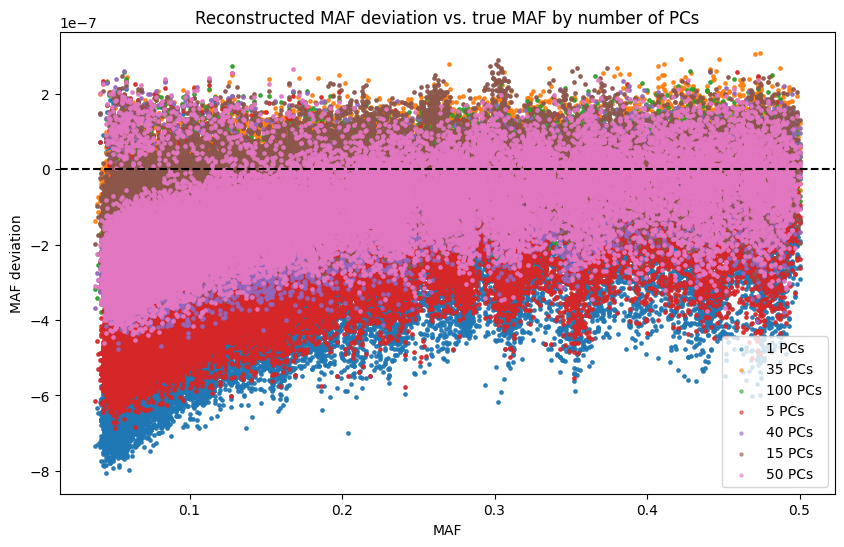

In [58]:

plt.figure(figsize=(10,6))
for pcs in df['nr_PCs'].unique():
    subset = df[df['nr_PCs'] == pcs]
    plt.scatter(subset['MAF'], subset['maf_deviation'], s=5, alpha=0.5, label=f"{pcs} PCs")

plt.axhline(0, color="black", linestyle="--")
plt.xlabel("MAF")
plt.ylabel("MAF deviation")
plt.legend()
plt.title("Reconstructed MAF deviation vs. true MAF by number of PCs")
plt.show()


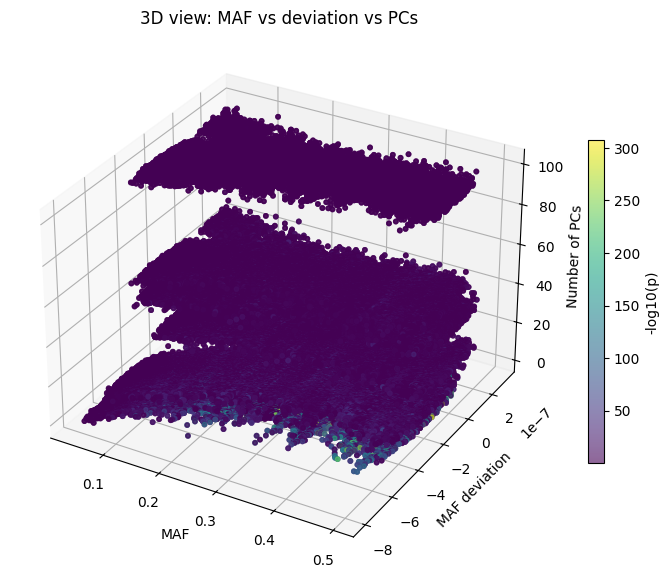

In [59]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter all points in 3D
sc = ax.scatter(
    df['MAF'], 
    df['maf_deviation'], 
    df['nr_PCs'], 
    c=df['-log10(p)'],   # color by -log10(p) if you want
    cmap="viridis", 
    alpha=0.6, s=10
)

ax.set_xlabel("MAF")
ax.set_ylabel("MAF deviation")
ax.set_zlabel("Number of PCs")
ax.set_title("3D view: MAF vs deviation vs PCs")

# Add colorbar for -log10(p)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("-log10(p)")

plt.show()

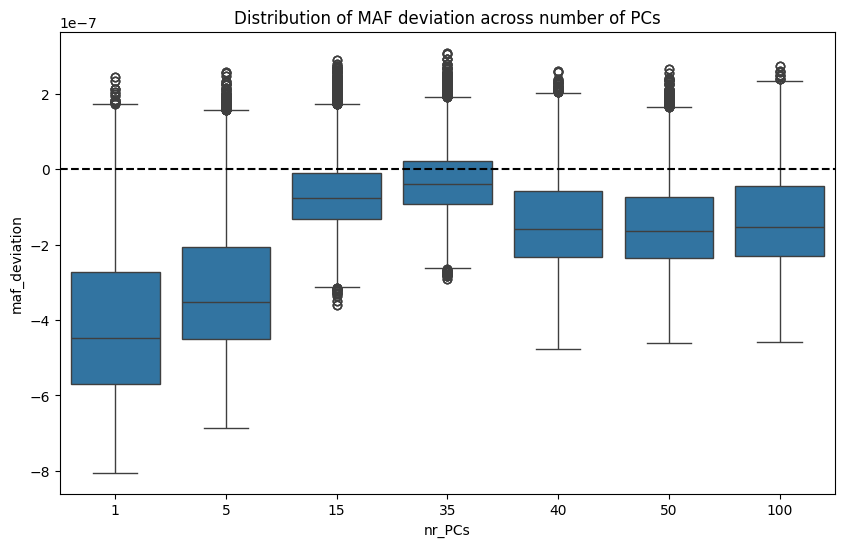

In [60]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="nr_PCs", y="maf_deviation")
plt.axhline(0, color="black", linestyle="--")
plt.title("Distribution of MAF deviation across number of PCs")
plt.show()


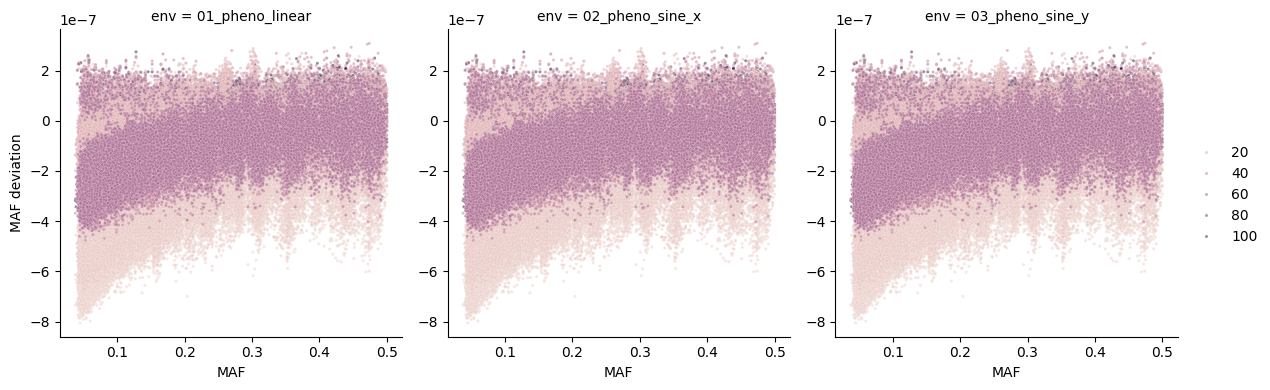

In [61]:
g = sns.FacetGrid(df, col="env", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.scatterplot, x="MAF", y="maf_deviation", hue="nr_PCs", alpha=0.5, s=5)
g.add_legend()
g.set_axis_labels("MAF", "MAF deviation")
plt.show()


/tmp/ipykernel_3403/1403457199.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = df.groupby(['MAF_bin','nr_PCs'])['maf_deviation'].mean().unstack()


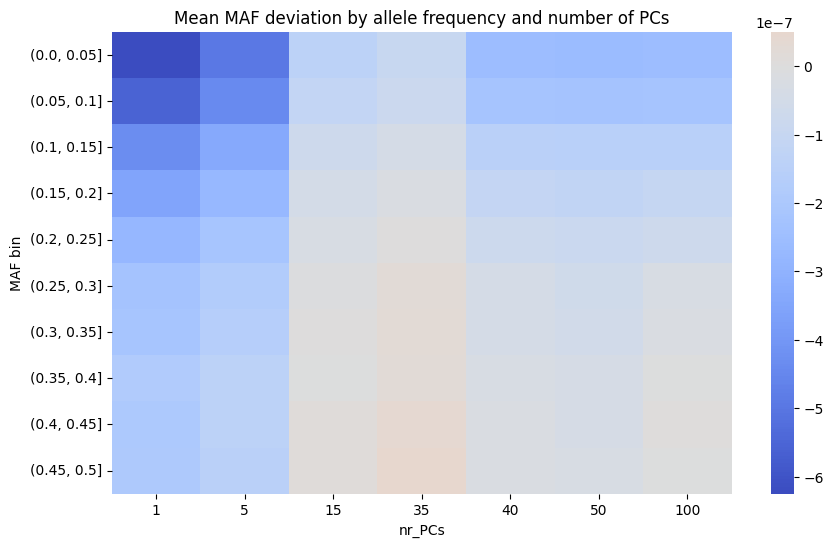

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns

# Bin MAF into categories
df['MAF_bin'] = pd.cut(df['MAF'], bins=np.linspace(0,0.5,11))

pivot = df.groupby(['MAF_bin','nr_PCs'])['maf_deviation'].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="coolwarm", center=0, annot=False)
plt.title("Mean MAF deviation by allele frequency and number of PCs")
plt.ylabel("MAF bin")
plt.xlabel("nr_PCs")
plt.show()


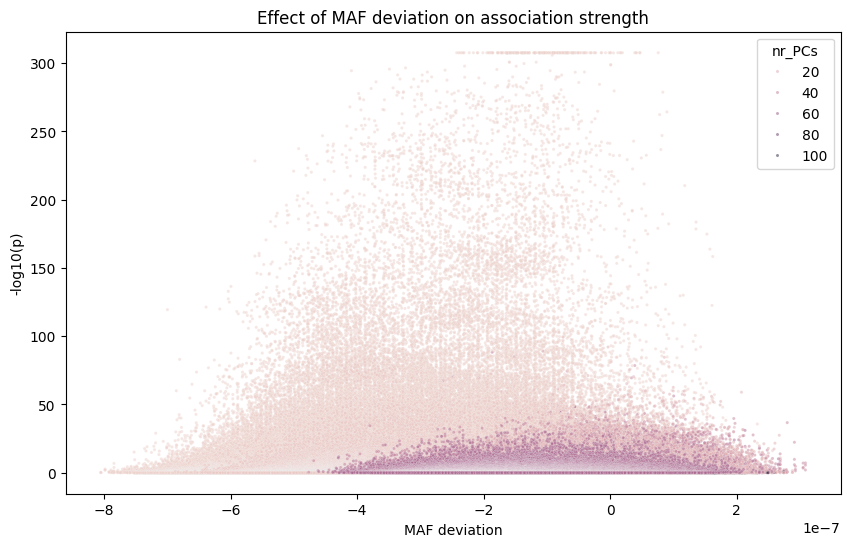

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, x="maf_deviation", y="-log10(p)", 
    hue="nr_PCs", alpha=0.5, s=5
)
plt.xlabel("MAF deviation")
plt.ylabel("-log10(p)")
plt.title("Effect of MAF deviation on association strength")
plt.show()


In [64]:
corrs = df.groupby("nr_PCs")[["maf_deviation","-log10(p)"]].corr().iloc[0::2, -1]
print(corrs)


nr_PCs               
1       maf_deviation    0.335357
5       maf_deviation    0.219242
15      maf_deviation    0.120675
35      maf_deviation    0.143501
40      maf_deviation    0.191846
50      maf_deviation    0.188244
100     maf_deviation    0.003509
Name: -log10(p), dtype: float64


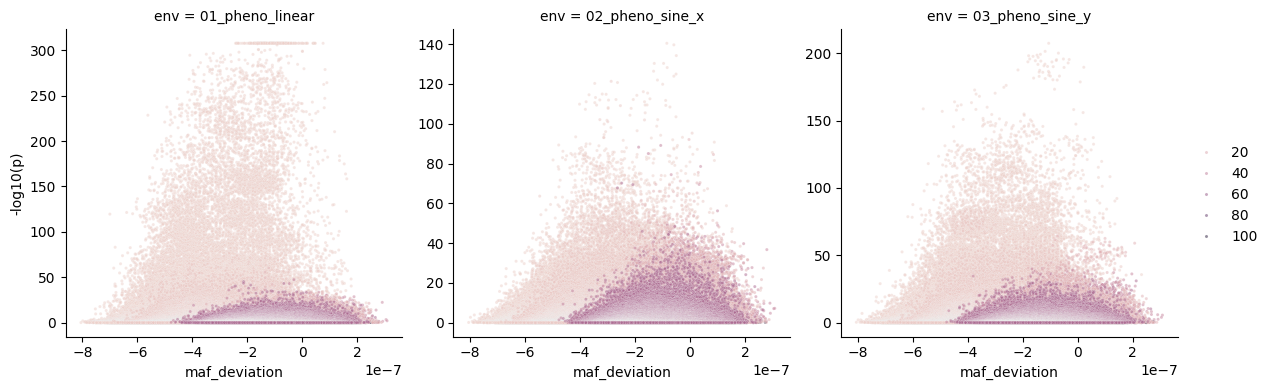

In [65]:
g = sns.FacetGrid(df, col="env", col_wrap=3, height=4, sharey=False)
g.map_dataframe(
    sns.scatterplot, x="maf_deviation", y="-log10(p)", hue="nr_PCs", alpha=0.5, s=5
)
g.add_legend()
plt.show()


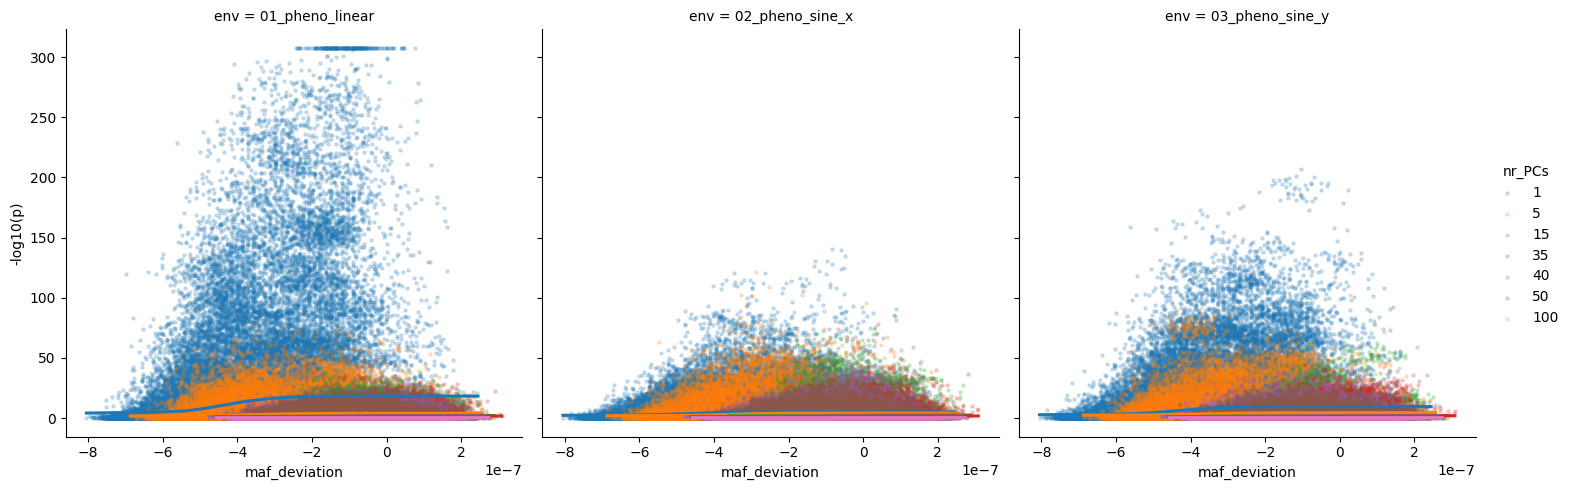

In [66]:
sns.lmplot(
    data=df, x="maf_deviation", y="-log10(p)",
    hue="nr_PCs", col="env", col_wrap=3,
    scatter_kws={"alpha":0.2, "s":5}, lowess=True
)

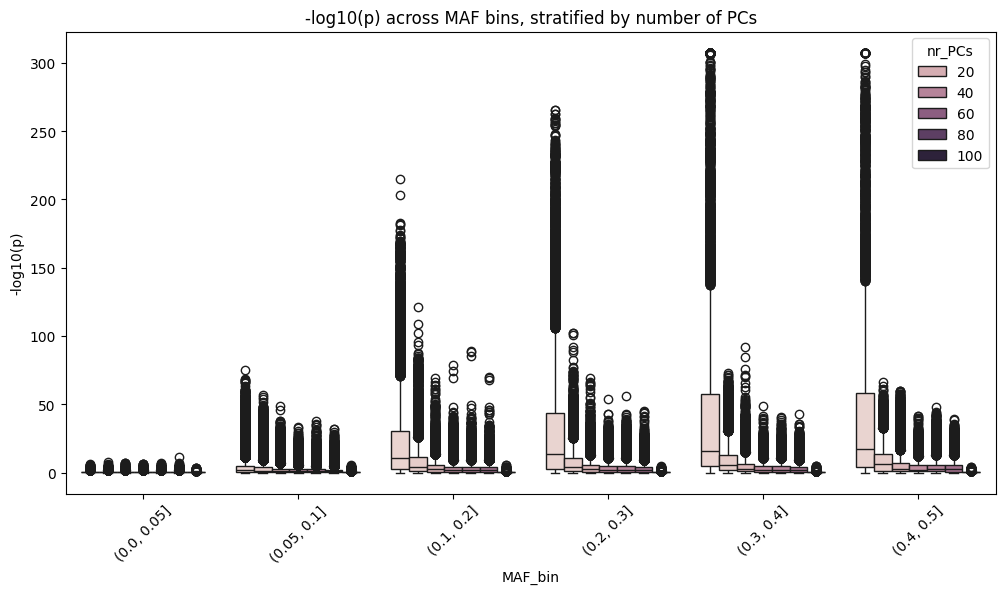

In [67]:
df['MAF_bin'] = pd.cut(df['MAF'], bins=[0,0.05,0.1,0.2,0.3,0.4,0.5])

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="MAF_bin", y="-log10(p)", hue="nr_PCs")
plt.xticks(rotation=45)
plt.title("-log10(p) across MAF bins, stratified by number of PCs")
plt.show()


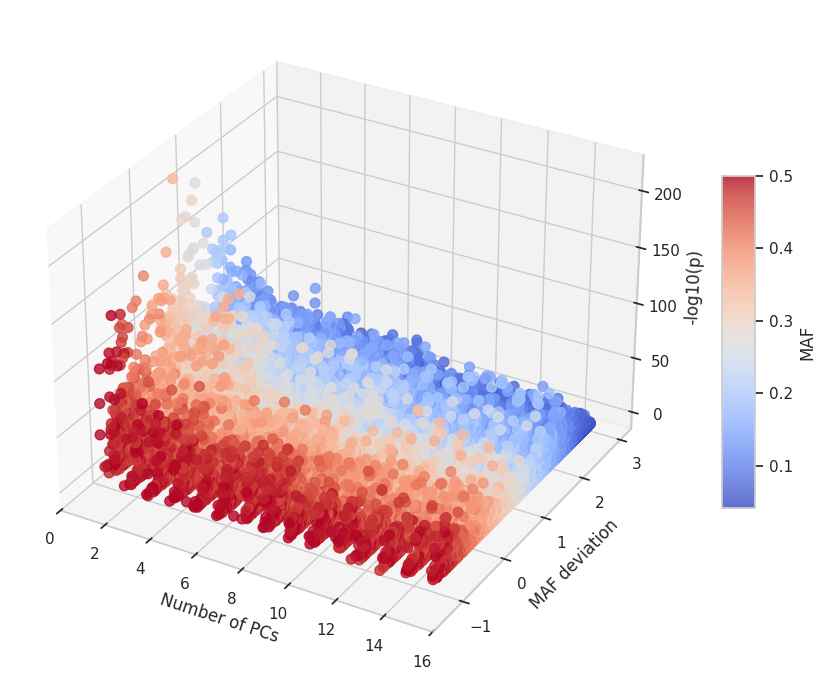

In [32]:
# Optional: make it look like seaborn
sns.set(style="whitegrid")

# Extract variables
x = df['nr_PCs']
y = df['maf_deviation']
z = df['-log10(p)']
hue = df['MAF']

# Create figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter with hue as MAF
sc = ax.scatter(x, y, z,
                c=hue,
                cmap='coolwarm',
                s=50,
                alpha=0.8)

# Labels
ax.set_xlabel('Number of PCs')
ax.set_ylabel('MAF deviation')
ax.set_zlabel('-log10(p)')

# Color bar for MAF
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('MAF')

plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import numpy as np

# Assuming df is your dataframe
bell_curves = []

for pcs, group in df.groupby("nr_PCs"):
    mean_dev = group["maf_deviation"].mean()
    std_dev = group["maf_deviation"].std(ddof=0)  # population std
    
    # Convert to z-scores
    z_scores = (group["maf_deviation"] - mean_dev) / std_dev
    
    bell_curves.append(pd.DataFrame({
        "nr_PCs": pcs,
        "maf_deviation": group["maf_deviation"],
        "z_score": z_scores
    }))

bell_curve_df = pd.concat(bell_curves)


In [34]:
bell_curve_df

nr_PCs  maf_deviation   z_score
0          1       0.423614 -1.215412
1          1       0.902201 -0.741702
2          1       0.817352 -0.825686
3          1       0.590096 -1.050627
4          1       0.678931 -0.962697
...      ...            ...       ...
3995      15      -0.327875 -1.951107
3996      15       2.591702  0.954498
3997      15       2.396063  0.759794
3998      15       1.351879 -0.279392
3999      15      -0.556725 -2.178862

[60000 rows x 3 columns]

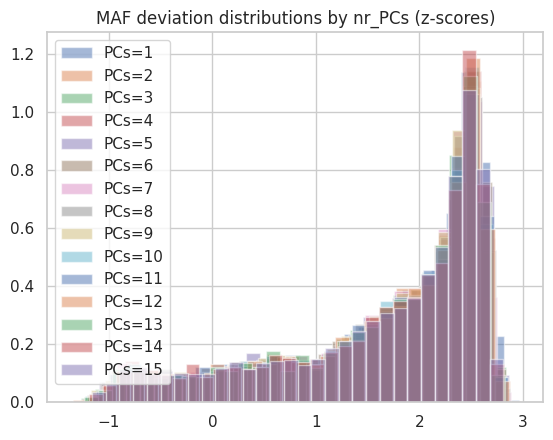

In [35]:
import matplotlib.pyplot as plt

for pcs in bell_curve_df["nr_PCs"].unique():
    subset = bell_curve_df[bell_curve_df["nr_PCs"] == pcs]
    plt.hist(subset["maf_deviation"], bins=30, density=True, alpha=0.5, label=f"PCs={pcs}")

plt.legend()
plt.title("MAF deviation distributions by nr_PCs (z-scores)")
plt.show()


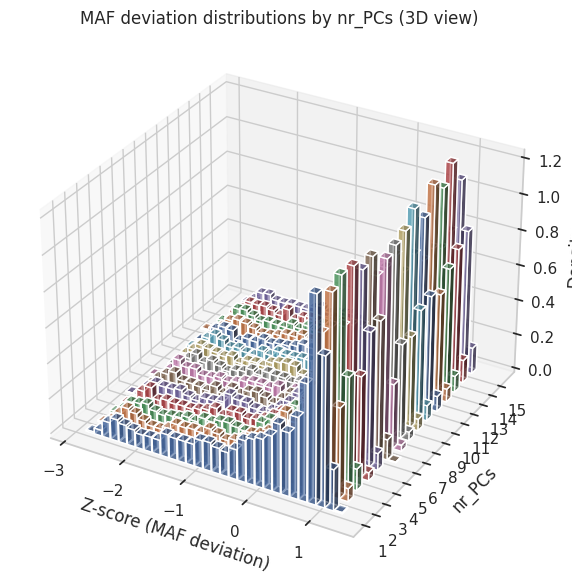

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assign numeric positions for nr_PCs so we can place them on the z-axis
pcs_positions = {pcs: i for i, pcs in enumerate(sorted(bell_curve_df["nr_PCs"].unique()))}

for pcs in bell_curve_df["nr_PCs"].unique():
    subset = bell_curve_df[bell_curve_df["nr_PCs"] == pcs]
    
    # Histogram data
    hist_vals, bin_edges = np.histogram(subset["z_score"], bins=30, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Z position for all bars in this group
    z_pos = np.full_like(bin_centers, pcs_positions[pcs], dtype=float)
    
    # Width and depth for bars
    dx = (bin_edges[1] - bin_edges[0]) * 0.9
    dy = 0.5  # thickness for the PC axis
    
    # Plot bars
    ax.bar3d(bin_centers, z_pos, np.zeros_like(hist_vals),
             dx, dy, hist_vals, alpha=0.6)

# Labels
ax.set_xlabel("Z-score (MAF deviation)")
ax.set_ylabel("nr_PCs")
ax.set_zlabel("Density")
ax.set_yticks(list(pcs_positions.values()))
ax.set_yticklabels(list(pcs_positions.keys()))
ax.set_title("MAF deviation distributions by nr_PCs (3D view)")

plt.show()
